Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
2025 - Bimestre 5 <br>


<h1><center> Procesamiento de Lenguaje Natural

Ayudantía 3: Transformers - RoBERTa, Llama y Gemini </center></h1>
        **Profesor**: Marcelo Mendoza<br>
        **Ayudante**: Miguel Fernández

---

#Introducción

En este documento se presenta el proceso de Fine-tuning del modelo RoBERTa para una tarea de análisis de sentimientos. En particular, se busca crear un clasificador que identifique el tipo de opinión en función de un review.

A diferencia del ejemplo visto en la clase 2, en esta experiencia se trabajará con pytorch.

Más información en: https://pytorch.org/






Dado el tamaño de los modelos transformer, se debe utilizar GPU para realizar los cálculos. Este entorno de google colab permite trabajar con el modelo T4 de manera gratuita (por un tiempo limitado). Para activarlo deben seguir los siguientes pasos:

1. Ir a "Entorno de ejecución".
2. Ir a "Cambiar tipo de entorno de ejecución".
3. Seleccionar GPU T4.



#Librerias

Se instala la librería transformers

In [ ]:
!pip install transformers

A continuación, se importan las librerías.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import RobertaModel, RobertaTokenizer, BertModel, BertTokenizer, DistilBertModel, DistilBertTokenizer

import json
from tqdm import tqdm

import logging
logging.basicConfig(level=logging.ERROR)

En la siguiente celda se asigna a la variable "device" el tipo de hardware que será utilizado para procesar los modelos. Al trabajar con arquitecturas transformer, en general, es necesario trabajar con GPU (cuda).

In [ ]:
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

Se monta google drive para facilitar la interacción.

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


#Cargar dataset

A continuación, se carga el dataset.

In [ ]:
path = "/content/drive/MyDrive/DOCTORADO/Ayudantía NLP (COURSERA)/versión 2/Ayudantía/AYUDANTIA 3/"

In [ ]:
df = pd.read_csv(path+'IMDB Dataset.csv')

In [ ]:
df.shape

(50000, 2)

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


A continuación, se presentan algunos ejemplos.

In [ ]:
df.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

##Análisis descriptivo dataset original

En primer lugar, se describirá la variable de respuesta. En este caso, sentiment.

In [ ]:
df.sentiment.value_counts()

,count
sentiment,
positive,25000
negative,25000


Se codifica la etiqueta con valores numéricos.

In [ ]:
df["sentiment_cod"]=df.sentiment.apply(lambda x: 1 if x=="positive" else 0)

In [ ]:
df.head()

,review,sentiment,sentiment_cod
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


##Crear dataset y dataloader

In [ ]:
new_df = df[['review', 'sentiment_cod']]
new_df.columns = ["review","Sentiment"]

In [ ]:
new_df.head()

,review,Sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
new_df.shape

(50000, 2)

En las siguientes celdas se presenta la implementación de la clase SentimentData que será necesaria para trabajar con la clase DataLoader. Esta última clase facilita la creación de los batch que serán necesarios para el proceso de entrenamiento.

A continuación, se define el tokenizador que utiliza roberta. Esto será necesario para construir SentimentData

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

En la siguiente celda se definen algunos hiperparámetros que serán necesarios para el entrenamiento del modelo.

In [ ]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 16
# EPOCHS = 1
LEARNING_RATE = 1e-05

En la siguiente celda se define la clase dataset para procesar el conjunto de datos.

In [ ]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len): #Se entrega el dataframe, el tokenizador y un largo máximo
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.review
        self.targets = self.data.Sentiment
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True, #en casos de oraciones mayores a max_len
            #pad_to_max_length=True, deprecado, ahora se usa padding
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        #Estos tres elementos son requeridos por el modelo.
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

A continuación, se genera un separación train (80%) y test (20%).

In [ ]:
train_size = 0.8
train_data=new_df.sample(frac=train_size,random_state=200) #Se obtiene una base de 80%
test_data=new_df.drop(train_data.index).reset_index(drop=True) #Se elimina train de la base new_df
train_data = train_data.reset_index(drop=True)


print("Dataset: {}".format(new_df.shape))
print("Train Dataset: {}".format(train_data.shape))
print("Test Dataset: {}".format(test_data.shape))

Dataset: (50000, 2)
Train Dataset: (40000, 2)
Test Dataset: (10000, 2)


In [ ]:
training_set = SentimentData(train_data, tokenizer, MAX_LEN)
testing_set = SentimentData(test_data, tokenizer, MAX_LEN)

Se definen hiperparámetros necesarios para trabajar con DataLoader.

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params) #Para train
testing_loader = DataLoader(testing_set, **test_params) #Para test

#Implementación RoBERTa

En la siguiente celda se crea el modelo RobertaClass. Para ello, se importa el modelo "roberta-base". Asimismo, la red propuesta incorpora una capa lineal de 768 a 768 y una capa lineal de salida de 768 a 2.

In [ ]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base") #Se importa el modelo roberta-base
        self.pre_classifier = torch.nn.Linear(768, 768) # Se genera una capa lineal de 768 a 768
        self.dropout = torch.nn.Dropout(0.2) #Se incorpora un dropout de 0.2. Esto es una estrategia de regularización
        self.classifier = torch.nn.Linear(768, 2) #Se crea una salida de 768 a 2 clases. El número de clases depende de la tarea que se desea resolver

    def forward(self, input_ids, attention_mask, token_type_ids): #Forward hace referencia a los pasos que debe seguir el modelo desde el input al output.
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

A continuación, se instancia el modelo RobertaClass

In [ ]:
model = RobertaClass()
model.to(device) # Se lleva el modelo a la GPU.

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

La última capa indica que se pasa de la representación vectorial de dimensión 768 a 2.

A continuación, se presenta la definición de la función de pérdida y del optimizador.

In [ ]:
loss_function = torch.nn.CrossEntropyLoss() #Función de pérdida adecuada para tarea de clasificación
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE) # ADAM es un buen optimizador. En general, se recomienda su uso.

In [ ]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

En la siguiente celda se presenta el loop de train del model.

##Train

In [ ]:
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return

A continuación, se presenta el entrenamiento del modelo para 1 época (el tiempo de entrenamiento es de 30 minutos, aproximadamente).

In [ ]:
EPOCHS = 1
for epoch in range(EPOCHS):
  train(epoch)

0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.6906404495239258
Training Accuracy per 5000 steps: 62.5


1250it [28:29,  1.37s/it]

The Total Accuracy for Epoch 0: 90.7125
Training Loss Epoch: 0.226092615018785
Training Accuracy Epoch: 90.7125


##Test

A continuación, se presentan los resultados al trabajar con el set de test.

In [ ]:
def valid(model, testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)

            outputs = model(ids, mask, token_type_ids).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)

            #Guardar salida
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.softmax(outputs,dim=1).squeeze(1).cpu().detach().numpy())

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_accu, np.array(fin_outputs), np.array(fin_targets)


In [ ]:
acc_ROBERTA, outputs_ROBERTA,targets_ROBERTA = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc_ROBERTA)

1it [00:01,  1.07s/it]

Validation Loss per 100 steps: 0.11109592020511627
Validation Accuracy per 100 steps: 93.75


625it [02:31,  4.14it/s]

Validation Loss Epoch: 0.16840854177698494
Validation Accuracy Epoch: 94.09
Accuracy on test data = 94.09%


In [ ]:
outputs_class_ROBERTA = np.argmax(outputs_ROBERTA,axis=1)
accuracy = metrics.accuracy_score(targets_ROBERTA, outputs_class_ROBERTA)

f1_score_micro = metrics.f1_score(targets_ROBERTA, outputs_class_ROBERTA, average='weighted')
f1_score_macro = metrics.f1_score(targets_ROBERTA, outputs_class_ROBERTA, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9409
F1 Score (Micro) = 0.9408822340054885
F1 Score (Macro) = 0.9408822340054885


In [ ]:
print(metrics.classification_report(targets_ROBERTA, outputs_class_ROBERTA))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      5024
           1       0.95      0.93      0.94      4976

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



# Implementación RoBERTa - Huggingface (Recomendado)

Se instalan las librerías necesarias.

In [ ]:
!pip install -q transformers datasets huggingface_hub ipdb evaluate accelerate

Se carga el dataset nuevamente.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import DatasetDict
from torch.nn import functional as F

import pathlib
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from datasets import Dataset, Value, ClassLabel, Features
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [ ]:
path = "/content/drive/MyDrive/DOCTORADO/Ayudantía NLP (COURSERA)/versión 2/Ayudantía/AYUDANTIA 3/"

In [ ]:
df = pd.read_csv(path + 'IMDB Dataset.csv')

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


La etiqueta de respuesta debe estar codificada como números enteros.

In [ ]:
df["label"] = df.sentiment.apply(lambda x: 1 if x=="positive" else 0)

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
df_train

,review,sentiment,label
39087,That's what I kept asking myself during the ma...,negative,0
30893,I did not watch the entire movie. I could not ...,negative,0
45278,A touching love story reminiscent of In the M...,positive,1
16398,This latter-day Fulci schlocker is a totally a...,negative,0
13653,"First of all, I firmly believe that Norwegian ...",negative,0
...,...,...,...
11284,`Shadow Magic' recaptures the joy and amazemen...,positive,1
44732,I found this movie to be quite enjoyable and f...,positive,1
38158,Avoid this one! It is a terrible movie. So wha...,negative,0
860,This production was quite a surprise for me. I...,positive,1


In [ ]:
df_test

,review,sentiment,label
33553,I really liked this Summerslam due to the look...,positive,1
9427,Not many television shows appeal to quite as m...,positive,1
199,The film quickly gets to a major chase scene w...,negative,0
12447,Jane Austen would definitely approve of this o...,positive,1
39489,Expectations were somewhat high for me when I ...,negative,0
...,...,...,...
28567,Although Casper van Dien and Michael Rooker ar...,negative,0
25079,I liked this movie. I wasn't really sure what ...,positive,1
18707,Yes non-Singaporean's can't see what's the big...,positive,1
15200,"As far as films go, this is likable enough. En...",negative,0


Se crea un dataset usando las herramientas de Huggingface.

In [ ]:
train = Dataset.from_pandas(df_train[["review","label"]])
test = Dataset.from_pandas(df_test[["review","label"]])

In [ ]:
train

Dataset({
    features: ['review', 'label', '__index_level_0__'],
    num_rows: 40000
})

In [ ]:
ds = DatasetDict()
ds

DatasetDict({
    
})

In [ ]:
ds["train"] = train
ds["test"] = test

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['review', 'label', '__index_level_0__'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['review', 'label', '__index_level_0__'],
        num_rows: 10000
    })
})

In [ ]:
ds["train"][0]

{'review': 'That\'s what I kept asking myself during the many fights, screaming matches, swearing and general mayhem that permeate the 84 minutes. The comparisons also stand up when you think of the one-dimensional characters, who have so little depth that it is virtually impossible to care what happens to them. They are just badly written cyphers for the director to hang his multicultural beliefs on, a topic that has been done much better in other dramas both on TV and the cinema.<br /><br />I must confess, I\'m not really one for spotting bad performances during a film, but it must be said that Nichola Burley (as the heroine\'s slutty best friend) and Wasim Zakir (as the nasty, bullying brother) were absolutely terrible. I don\'t know what acting school they graduated from, but if I was them I\'d apply for a full refund post haste. Only Samina Awan in the lead role manages to impress in a cast of so-called British talent that we\'ll probably never hear from again. At least, that\'s t

## Instanciar modelo

In [ ]:
from transformers import set_seed
set_seed(0) #Se establece una semilla para reproducir resultados

In [ ]:
#from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
#from transformers import RobertaModel, RobertaTokenizer, RobertaForSequenceClassification

Se define la codificación sobre los labels.

In [ ]:
id2label = {0: 'negative', 1: 'positive'}
label2id = {'negative': 0, 'positive':1}

In [ ]:
model_name = "roberta-base"
# dccuchile/bert-base-spanish-wwm-cased
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2, #número de clases
    id2label=id2label, #codificación id -> label
    label2id=label2id) #codificación label -> id

tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Se aplica el tokenizador al texto tanto con train como con test.

In [ ]:
tokenizer.model_max_length = 130

def tokenize(example):
    return tokenizer(example["review"], truncation="longest_first")

tokenized_ds = ds.map(tokenize)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['review', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['review', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 10000
    })
})

Se define la métricas f1 score para evaluar el proceso de entrenamiento.

In [ ]:
import evaluate
f1 = evaluate.load("f1") #probar con f1
accuracy_metric = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return f1.compute(references=labels,predictions=predictions)
'''
Por defecto, evaluate.load("f1") usa average="binary", lo que NO es correcto para multiclase.
Para resolver lo anterior, se puede utilizar average="macro"   # o "micro", "weighted"
'''

'\nPor defecto, evaluate.load("f1") usa average="binary", lo que NO es correcto para multiclase.\nPara resolver lo anterior, se puede utilizar average="macro"   # o "micro", "weighted"\n'

In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import precision_recall_fscore_support


# Este "recolector" de datos hace que los distintos lotes que
# procesa BERT tengan todos el mismo largo. Para eso, rellena
# con `padding`.
data_collator = DataCollatorWithPadding(tokenizer, padding="longest")

In [ ]:
# Argumentos varios de entrenamiento
# - Tamaño de lote
# - Cada cuánto evaluamos los resultados
# - Si elegimos el mejor resultado al final de cada evaluación
# - otros
train_args = TrainingArguments(
    report_to="none",
    output_dir='clf_sentiment',
    eval_strategy="steps",
    save_strategy = "steps",
    learning_rate=2e-5,
    warmup_steps=250,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1, #solo por 1 época
    weight_decay=0.18,
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

El proceso de entrenamiento toma 25 minutos, aproximadamente.

In [ ]:
trainer = Trainer(
    model=model,
    args=train_args,
    data_collator=data_collator,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss,Validation Loss,F1
100,No log,0.456743,0.856685
200,No log,0.363085,0.859415
300,No log,0.281129,0.889022
400,No log,0.278123,0.892806
500,0.381300,0.281522,0.888797
600,0.381300,0.255821,0.896872
700,0.381300,0.233527,0.905356
800,0.381300,0.255830,0.904681
900,0.381300,0.229928,0.909466
1000,0.248800,0.228294,0.909001


TrainOutput(global_step=1250, training_loss=0.29924920654296877, metrics={'train_runtime': 1696.5283, 'train_samples_per_second': 23.578, 'train_steps_per_second': 0.737, 'total_flos': 2672221656000000.0, 'train_loss': 0.29924920654296877, 'epoch': 1.0})

In [ ]:
results = trainer.evaluate(tokenized_ds["test"])

In [ ]:
results

{'eval_loss': 0.22072485089302063,
 'eval_f1': 0.9121768304716795,
 'eval_runtime': 65.6775,
 'eval_samples_per_second': 152.259,
 'eval_steps_per_second': 4.766,
 'epoch': 1.0}

##Guardar modelo

In [ ]:
path

'/content/drive/MyDrive/DOCTORADO/Ayudantía NLP (COURSERA)/versión 2/Ayudantía/AYUDANTIA 3/'

In [ ]:
trainer.save_model(path + "Modelo IMDB")

Al guardar el modelo, se crean los siguientes archivos:

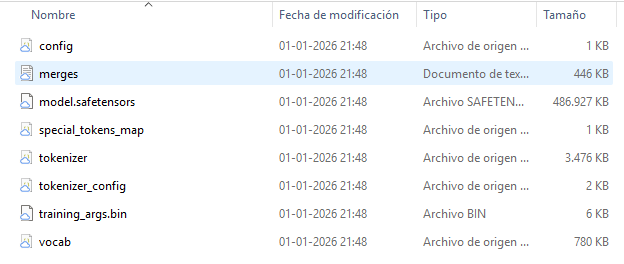

##Cargar modelo

In [ ]:
model_name = "roberta-base"
device = "cuda" if torch.cuda.is_available() else "cpu"
model_base = AutoModelForSequenceClassification.from_pretrained(path + "Modelo IMDB",
                                                   num_labels=2)#,
                                                   #ignore_mismatched_sizes=True)
model_base.to(device)

tokenizer = AutoTokenizer.from_pretrained(model_name)

##Evaluación manual

In [ ]:
df_test = pd.DataFrame(ds["test"])

In [ ]:
df_test

,review,label,__index_level_0__
0,I really liked this Summerslam due to the look...,1,33553
1,Not many television shows appeal to quite as m...,1,9427
2,The film quickly gets to a major chase scene w...,0,199
3,Jane Austen would definitely approve of this o...,1,12447
4,Expectations were somewhat high for me when I ...,0,39489
...,...,...,...
9995,Although Casper van Dien and Michael Rooker ar...,0,28567
9996,I liked this movie. I wasn't really sure what ...,1,25079
9997,Yes non-Singaporean's can't see what's the big...,1,18707
9998,"As far as films go, this is likable enough. En...",0,15200


In [ ]:
def predict(text):
    encoding = tokenizer.encode_plus(text, truncation="longest_first")

    inputs = {
        k:torch.LongTensor(encoding[k]).reshape(1, -1).to(device) for k in {"input_ids", "attention_mask"}#, "token_type_ids"}
    }

    with torch.no_grad():
      logits = model_base(**inputs).logits

    predicted_class_id = logits.argmax().item()
#    chars = list(zip(label2id, list(output.logits[0].detach().cpu().numpy() > 0)))

    return model_base.config.id2label[predicted_class_id]

resultado = []
for i in tqdm(range(df_test.shape[0])): #df_test.shape[0]
  resultado.append(predict(df_test["review"][i]))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
len(resultado)

10000

In [ ]:
df_test["predict"] = resultado
df_test["predict_cod"] = df_test.predict.apply(lambda x: 0 if x=="negative" else 1)
print(classification_report(df_test.label,df_test.predict_cod))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4961
           1       0.95      0.95      0.95      5039

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



# Uso de Llama-3.2-3B-Instruct

En esta sección se presenta el procedimiento para trabajar con los modelos LLaMA 3.2-3B y Gemini.

In [1]:
!pip install transformers

In [2]:
import torch
from transformers import pipeline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Cargar token hugging face

Antes de importar el modelo es necesario utilizar el token de hugging face (ver presentación **Instrucciones para trabajar con Llama 3B**)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Modelo Llama-3.2-3B-Instruct

Una vez cargado el token, se puede importar el modelo. En este caso, se recomienda observar los recursos que serán utilizados. Para ello, debe hacer click en la esquina superior derecha, donde dice **T4, RAM y Disco**. Se debería desplegar el detalle del uso de hardware.

In [ ]:
model_id = "meta-llama/Llama-3.2-3B-Instruct"
pipe = pipeline( #Se trabaja con pipeline para facilitar el uso del LLM
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    device_map=device,
)

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Device set to use cuda


Al revisar el uso de hardware, se puede observar que el LLM de 3B requiere 6.1 GB.

## Crear pregunta

A continuación, se presenta la forma de obtener una respuesta por parte del modelo.

En primer lugar, es necesario definir el prompt. Esto se realizará con la variable **messages**

In [ ]:
question = "Who is Geoffrey Hinton?"
messages = [{"role": "user", "content": f'''answer the following question: {question}. '''}] #Note que estamos usando f-string para facilitar la lectura de la variable question

## Obtener salida

Luego, se entrega el mensaje a pipe. La respuesta generada está almacenada en la variable outputs.

In [ ]:
outputs = pipe(messages, max_new_tokens=256)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Como se puede observar, **outputs** corresponde a una lista que contiene un diccionario.

In [ ]:
outputs

[{'generated_text': [{'role': 'user',
    'content': 'answer the following question: Who is Geoffrey Hinton?. '},
   {'role': 'assistant',
    'content': 'Geoffrey Hinton is a Canadian computer scientist and professor emeritus at the University of Toronto. He is known for his groundbreaking contributions to the field of artificial intelligence, particularly in the development of deep learning techniques.\n\nHinton was born in 1947 in England and studied mathematics and computer science at Cambridge University. He later moved to Canada and worked at the University of Toronto, where he became a prominent researcher in the field of neural networks.\n\nHinton\'s most notable contributions include:\n\n1. Development of the backpropagation algorithm: Hinton, along with Yann LeCun and Yoshua Bengio, developed the backpropagation algorithm, which is a key component of many deep learning techniques.\n2. Introduction of the concept of deep neural networks: Hinton\'s work on deep neural networks,

En la siguiente celda podemos seleccionar el valor inicial de la lista.

In [ ]:
outputs[0]

{'generated_text': [{'role': 'user',
   'content': 'answer the following question: Who is Geoffrey Hinton?. '},
  {'role': 'assistant',
   'content': 'Geoffrey Hinton is a Canadian computer scientist and professor emeritus at the University of Toronto. He is known for his groundbreaking contributions to the field of artificial intelligence, particularly in the development of deep learning techniques.\n\nHinton was born in 1947 in England and studied mathematics and computer science at Cambridge University. He later moved to Canada and worked at the University of Toronto, where he became a prominent researcher in the field of neural networks.\n\nHinton\'s most notable contributions include:\n\n1. Development of the backpropagation algorithm: Hinton, along with Yann LeCun and Yoshua Bengio, developed the backpropagation algorithm, which is a key component of many deep learning techniques.\n2. Introduction of the concept of deep neural networks: Hinton\'s work on deep neural networks, whi

Luego, podemos seleccionar el coontenido de **generated_text**.

In [ ]:
outputs[0]["generated_text"]

[{'role': 'user',
  'content': 'answer the following question: Who is Geoffrey Hinton?. '},
 {'role': 'assistant',
  'content': 'Geoffrey Hinton is a Canadian computer scientist and professor emeritus at the University of Toronto. He is known for his groundbreaking contributions to the field of artificial intelligence, particularly in the development of deep learning techniques.\n\nHinton was born in 1947 in England and studied mathematics and computer science at Cambridge University. He later moved to Canada and worked at the University of Toronto, where he became a prominent researcher in the field of neural networks.\n\nHinton\'s most notable contributions include:\n\n1. Development of the backpropagation algorithm: Hinton, along with Yann LeCun and Yoshua Bengio, developed the backpropagation algorithm, which is a key component of many deep learning techniques.\n2. Introduction of the concept of deep neural networks: Hinton\'s work on deep neural networks, which consist of multiple

In [ ]:
len(outputs[0]["generated_text"])

2

Luego, seleccionamos el segundo elemento de la lista y nos quedamos con el contenido de **content**.

In [ ]:
outputs[0]["generated_text"][1]["content"]

'Geoffrey Hinton is a Canadian computer scientist and professor emeritus at the University of Toronto. He is known for his groundbreaking contributions to the field of artificial intelligence, particularly in the development of deep learning techniques.\n\nHinton was born in 1947 in England and studied mathematics and computer science at Cambridge University. He later moved to Canada and worked at the University of Toronto, where he became a prominent researcher in the field of neural networks.\n\nHinton\'s most notable contributions include:\n\n1. Development of the backpropagation algorithm: Hinton, along with Yann LeCun and Yoshua Bengio, developed the backpropagation algorithm, which is a key component of many deep learning techniques.\n2. Introduction of the concept of deep neural networks: Hinton\'s work on deep neural networks, which consist of multiple layers of interconnected nodes (neurons), helped to establish the field as a major area of research in artificial intelligence.

In [ ]:
respuesta_3B = outputs[0]["generated_text"][1]["content"]
respuesta_3B

'Geoffrey Hinton is a Canadian computer scientist and professor emeritus at the University of Toronto. He is known for his groundbreaking contributions to the field of artificial intelligence, particularly in the development of deep learning techniques.\n\nHinton was born in 1947 in England and studied mathematics and computer science at Cambridge University. He later moved to Canada and worked at the University of Toronto, where he became a prominent researcher in the field of neural networks.\n\nHinton\'s most notable contributions include:\n\n1. Development of the backpropagation algorithm: Hinton, along with Yann LeCun and Yoshua Bengio, developed the backpropagation algorithm, which is a key component of many deep learning techniques.\n2. Introduction of the concept of deep neural networks: Hinton\'s work on deep neural networks, which consist of multiple layers of interconnected nodes (neurons), helped to establish the field as a major area of research in artificial intelligence.

# Gemini

Para obtener la API key deben ingresar a https://aistudio.google.com/app/api-keys.

En primer lugar, se debe cargar la API key.

In [ ]:
from API_gemini import API_KEY_GEMINI

In [ ]:
from google import genai

In [ ]:
client = genai.Client(api_key=API_KEY_GEMINI)

response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents="Who is Geoffrey Hinton?"
)
print(response.text)

**Geoffrey Hinton** is a distinguished British-Canadian cognitive psychologist and computer scientist, widely regarded as one of the **"Godfathers of AI"** (Artificial Intelligence).

Here's a breakdown of his significance:

1.  **Pioneering Work in Deep Learning:** He is most famous for his pioneering work on artificial neural networks, which laid much of the theoretical and practical groundwork for the modern field of **deep learning**. For decades, neural networks were considered a fringe area, but Hinton's persistence and groundbreaking research helped bring them to the forefront.

2.  **Backpropagation Algorithm:** He was a key figure in developing and popularizing the **backpropagation algorithm**, which is fundamental for training multi-layer neural networks by efficiently calculating the gradient of the loss function with respect to the weights. This algorithm allows neural networks to learn from data.

3.  **Academic and Industry Roles:**
    *   For many years, he was a profe